# Python入門 2_02
## 回帰分析

In [1]:
# パッケージの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Jupyter上で図を出すためのコマンド
%matplotlib inline　

ImportError: No module named 'seaborn'

### 単回帰分析
#### データの準備

In [2]:
# 中古車データの読み込み
car_data = pd.read_csv('./data/car_data.csv', dtype = {'id': 'object'})

#### データの概要
* id: 車両番号(一意に識別する値)
* price: 価格（万円）
* distance: 走行距離（千km）
* month: 生産されてからの経過月数（ヶ月）
* condition: 車の状態（0~10までの値。10が最も良い状態）
* navi: ナビが付いているか否か（1が付属）

In [3]:
# データの冒頭を確認
car_data.head()

,id,price,distance,month,condition,navi
0,1,91.0,3.0,17.0,5.0,0
1,2,95.5,3.0,17.0,4.5,0
2,3,84.7,2.0,17.0,4.5,0
3,4,88.0,6.0,25.0,4.0,1
4,5,100.0,6.0,12.0,4.5,1


In [4]:
# データの基本統計量を確認
car_data.describe(include='all')

,id,price,distance,month,condition,navi
count,90,90.000000,88.000000,89.000000,88.000000,90.000000
unique,90,NaN,NaN,NaN,NaN,NaN
top,3,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,85.452222,13.829545,15.977528,4.857955,0.344444
std,NaN,17.867108,17.676676,6.306522,1.277455,0.477849
min,NaN,39.200000,1.000000,5.000000,3.500000,0.000000
25%,NaN,77.225000,3.000000,11.000000,4.000000,0.000000
50%,NaN,91.450000,6.000000,14.000000,4.500000,0.000000
75%,NaN,97.450000,15.750000,24.000000,5.000000,1.000000


* countの値が各列で異なる

In [5]:
# 欠損値があるか確認
car_data.isnull().any()

id           False
price        False
distance      True
month         True
condition     True
navi         False
dtype: bool

In [6]:
#  欠損値がある行を除く
car_data_clean = car_data.dropna()

In [7]:
car_data_clean.isnull().any()

id           False
price        False
distance     False
month        False
condition    False
navi         False
dtype: bool

In [8]:
car_data_clean.shape

(85, 6)

In [9]:
car_data_clean.tail()

,id,price,distance,month,condition,navi
85,86,96.3,7.0,13.0,4.5,0
86,87,79.4,6.0,24.0,4.5,0
87,88,100.5,6.0,12.0,5.0,0
88,89,100.0,2.0,9.0,4.5,0
89,90,50.6,59.0,25.0,4.0,1


* indexと行数が揃っていない

In [10]:
# indexの番号と行数を揃える
car_data_clean = car_data_clean.reset_index(drop=True)

In [11]:
car_data_clean.tail()

,id,price,distance,month,condition,navi
80,86,96.3,7.0,13.0,4.5,0
81,87,79.4,6.0,24.0,4.5,0
82,88,100.5,6.0,12.0,5.0,0
83,89,100.0,2.0,9.0,4.5,0
84,90,50.6,59.0,25.0,4.0,1


In [12]:
# データの基本統計量
car_data_clean.describe(include='all')

,id,price,distance,month,condition,navi
count,85,85.000000,85.000000,85.000000,85.000000,85.000000
unique,85,NaN,NaN,NaN,NaN,NaN
top,3,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,86.076471,13.858824,15.952941,4.888235,0.329412
std,NaN,17.654047,17.768453,6.271451,1.289556,0.472789
min,NaN,39.200000,1.000000,5.000000,3.500000,0.000000
25%,NaN,80.500000,3.000000,11.000000,4.000000,0.000000
50%,NaN,91.900000,6.000000,14.000000,4.500000,0.000000
75%,NaN,97.700000,15.000000,24.000000,5.000000,1.000000


* countの値が各列で同じになった

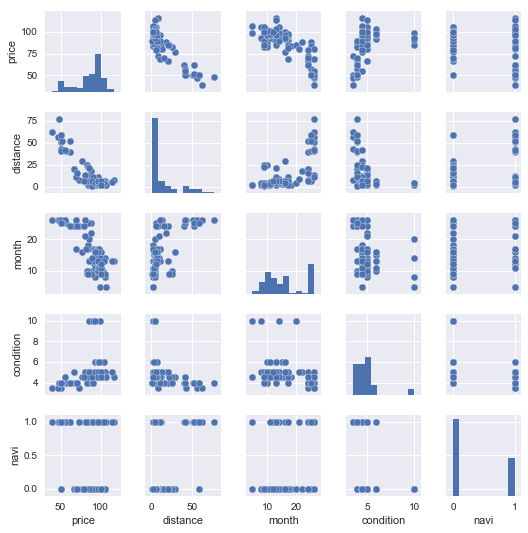

In [13]:
# 散布図行列を表示する
sns.pairplot(car_data_clean[['price', 'distance', 'month', 'condition', 'navi']], size=1.5)

##### 相関係数を求める

In [14]:
# 相関係数を計算する
car_data_clean[['price', 'distance', 'month', 'condition', 'navi']].corr()

,price,distance,month,condition,navi
price,1.000000,-0.878428,-0.803844,0.355469,-0.365761
distance,-0.878428,1.000000,0.675227,-0.371139,0.483168
month,-0.803844,0.675227,1.000000,-0.340694,0.442925
condition,0.355469,-0.371139,-0.340694,1.000000,-0.300126
navi,-0.365761,0.483168,0.442925,-0.300126,1.000000


#### 単回帰分析の実行

##### 今回は機械学習のアルゴリズムが多く実装されている, scikit-learnというパッケージを使って行う. 

- scikit-learn: http://scikit-learn.org/stable/

In [15]:
from sklearn.linear_model import LinearRegression # 線形回帰を行うための関数
from sklearn.metrics import r2_score # 決定係数を出すための関数
from sklearn.metrics import mean_squared_error # 平均2乗誤差を求めるための関数

In [16]:
# 回帰を行うためのデータを準備
x = car_data_clean[['month']]
y = car_data_clean[['price']]

In [17]:
x.head()

,month
0,17.0
1,17.0
2,17.0
3,25.0
4,12.0


In [18]:
y.head()

,price
0,91.0
1,95.5
2,84.7
3,88.0
4,100.0


In [19]:
# 回帰を実行
reg1 = LinearRegression() # インスタンスを生成
reg1.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
# 傾きを表示
print(reg1.coef_)

[[-2.26280873]]


In [21]:
# 切片を表示
print(reg1.intercept_) 

[ 122.17492522]


In [22]:
# 求めた傾きと切片を使って値を出す
y_reg1 = reg1.predict(x)

##### 決定係数を求める

In [23]:
# 決定係数を表示
print(r2_score(y, y_reg1))

0.646164541012


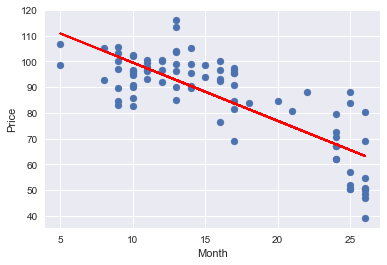

In [24]:
# 結果を図示
plt.scatter(x, y)
plt.plot(x, y_reg1, color='red')
plt.xlabel('Month')
plt.ylabel('Price')

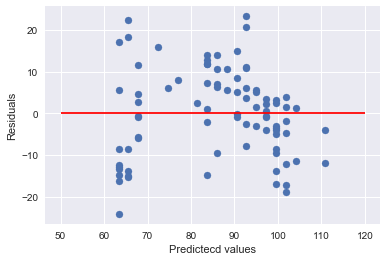

In [25]:
# 残差を図示
plt.scatter(y_reg1, y - y_reg1)
plt.xlabel('Predictecd values') 
plt.ylabel('Residuals')
plt.hlines(y=0, xmin=50, xmax=120, color='red')

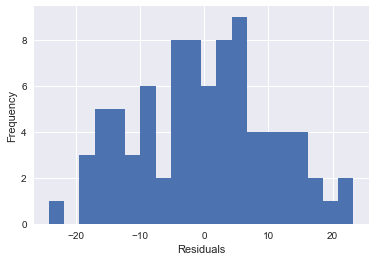

In [26]:
# 残差のヒストグラムを表示
plt.hist((y - y_reg1)['price'], bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

#### テストデータに対する予測

In [27]:
# データの読み込み
car_data_predict = pd.read_csv('./data/car_data_predict.csv', dtype = {'id': 'object'})

In [28]:
# データを確認
car_data_predict.head()

,id,price,distance,month,condition,navi
0,91,88.9,3,18,5.0,0
1,92,95.4,4,10,5.0,0
2,93,97.2,6,13,4.5,0
3,94,102.9,7,11,4.5,0
4,95,61.0,38,25,4.0,1


In [29]:
# 予測に使うデータを準備
x_test = car_data_predict[['month']]
y_test = car_data_predict[['price']]

In [30]:
# 予測を実施
y_pred_reg1 = reg1.predict(x_test)

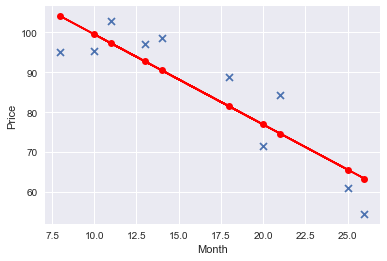

In [31]:
# 結果を図示
plt.scatter(x_test, y_test, marker='x')
plt.plot(x_test, y_pred_reg1, marker='o', color='red')
plt.xlabel('Month')
plt.ylabel('Price')

In [32]:
# テストデータに対する平均2乗誤差を求める
print(mean_squared_error(y_test, y_pred_reg1))

49.0532399902


### 重回帰分析

#### 2変数(month, distance)

In [33]:
# 説明変数を準備
X_2 = car_data_clean[['month', 'distance']]

In [34]:
# 重回帰を実行
reg2 = LinearRegression()
reg2.fit(X_2, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [35]:
# 係数を表示
print(reg2.coef_)

[[-1.09017908 -0.61295583]]


In [36]:
# 切片を表示
print(reg2.intercept_)

[ 111.96288]


In [37]:
# 求めた係数と切片を使って予測
y_reg2 = reg2.predict(X_2)

In [38]:
# 決定係数を表示
print(r2_score(y, y_reg2))

0.853236900906


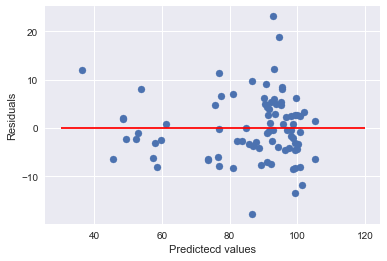

In [39]:
# 残差を図示
plt.scatter(y_reg2, y - y_reg2)
plt.xlabel('Predictecd values') 
plt.ylabel('Residuals')
plt.hlines(y=0, xmin=30, xmax=120, color='red')

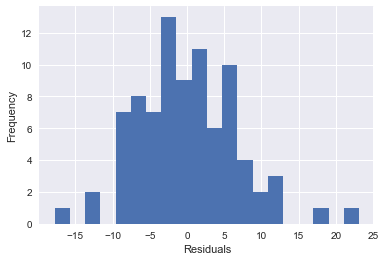

In [40]:
# 残差のヒストグラムを表示
plt.hist((y - y_reg2)['price'], bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [41]:
# テストデータに対する予測
X_2_test = car_data_predict[['month', 'distance']]
y_pred_reg2 = reg2.predict(X_2_test)

In [42]:
# テストデータに対する平均2乗誤差を求める
print(mean_squared_error(y_test, y_pred_reg2))

39.1774949817


#### 全変数 (month, distance, condition, navi)

In [43]:
# 説明変数を準備
X_all = car_data_clean[['month', 'distance', 'condition', 'navi']]

In [44]:
# 重回帰を実施
reg3 = LinearRegression()
reg3.fit(X_all, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [45]:
# 係数を表示
reg3.coef_

array([[-1.17069006, -0.65781191,  0.14411661,  5.28345614]])

In [46]:
# 切片を表示
reg3.intercept_

array([ 111.4240109])

In [47]:
# 求めた係数と切片を使って予測
y_reg3 = reg3.predict(X_all)

In [48]:
# 決定係数を表示
print(r2_score(y, y_reg3))

0.867874470355


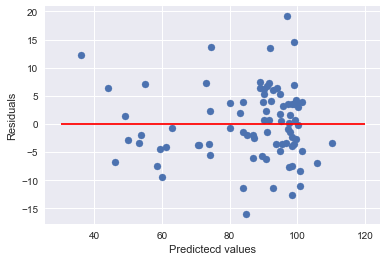

In [49]:
# 残差を図示
plt.scatter(y_reg3, y - y_reg3)
plt.xlabel('Predictecd values') 
plt.ylabel('Residuals')
plt.hlines(y=0, xmin=30, xmax=120, color='red')

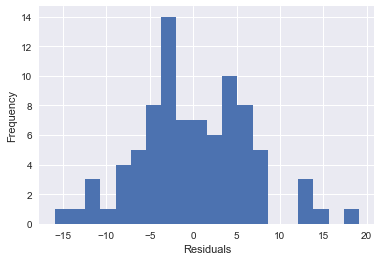

In [50]:
# 残差のヒストグラムを表示
plt.hist((y - y_reg3)['price'], bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [51]:
# テストデータに対する予測
X_all_test = car_data_predict[['month', 'distance', 'condition', 'navi']]
y_pred_reg3 = reg3.predict(X_all_test)

In [52]:
# テストデータの平均2乗誤差を求める
print(mean_squared_error(y_test, y_pred_reg3))

39.2148312166


### 参考1: stasmodelsを使う
stastmodelsを使うと, Rのように統計量を簡単に出すことができる.

- statsmodels: http://www.statsmodels.org/stable/index.html#

In [53]:
import statsmodels.api as sm

/Users/ryo_furukawa/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### 全変数を使った重回帰

In [54]:
# 切片を推定するために1の列を加える
X_all_w_bias = sm.add_constant(X_all)
X_all_w_bias.head()

,const,month,distance,condition,navi
0,1.0,17.0,3.0,5.0,0
1,1.0,17.0,3.0,4.5,0
2,1.0,17.0,2.0,4.5,0
3,1.0,25.0,6.0,4.0,1
4,1.0,12.0,6.0,4.5,1


In [55]:
# 回帰分析を実行
model3_sm = sm.OLS(y.values, X_all_w_bias)
reg3_sm = model3_sm.fit()

In [56]:
# 回帰分析の結果を表示
reg3_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     131.4
Date:                Mon, 25 Sep 2017   Prob (F-statistic):           2.47e-34
Time:                        21:02:39   Log-Likelihood:                -278.12
No. Observations:                  85   AIC:                             566.2
Df Residuals:                      80   BIC:                             578.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.4240      4.078     27.324      0.000     103.309     119.539
month         -1.1707      0.159     -7.381      0.000      -1.486      -0.855
distance      -0.6578      0.058    -11.387      0.000      -0.773      -0.543
condition      0.1441      0.609      0.236      0.814      -1.069       1.357
navi           5.2835      1.777      2.973      0.004       1.747       8.819
==============================================================================
Omnibus:                        2.134   Durbin-Watson:                   2.217
Prob(Omnibus):                  0.344   Jarque-Bera (JB):                1.487
Skew:                           0.271   Prob(JB):                        0.476
Kurtosis:                       3.354   Cond. No.                         155.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 参考2: AICを使った変数選択

AIC(赤池情報量規準)が最小の説明変数の組を求める.

例えば, RのMASSパッケージにはstepAIC()という関数がある. 

今回は, 総当たりでAICの最小値を求めてみる.

In [57]:
import itertools # イタレータを作るためのパッケージ

In [58]:
# 説明変数の組のリストを作る
pred_list = ['month', 'distance', 'condition', 'navi']
pred_comb_list = []
for i in range(4):
    pred_comb_list.extend(list(itertools.combinations(pred_list, i + 1)))

In [59]:
pred_comb_list

[('month',),
 ('distance',),
 ('condition',),
 ('navi',),
 ('month', 'distance'),
 ('month', 'condition'),
 ('month', 'navi'),
 ('distance', 'condition'),
 ('distance', 'navi'),
 ('condition', 'navi'),
 ('month', 'distance', 'condition'),
 ('month', 'distance', 'navi'),
 ('month', 'condition', 'navi'),
 ('distance', 'condition', 'navi'),
 ('month', 'distance', 'condition', 'navi')]

In [60]:
# 決定係数のリストを作る
# AICのリストを作る
pred_rsq_list = []
pred_aic_list = []
for predictor in pred_comb_list:
    x = car_data_clean[list(predictor)]
    x_w_bias = sm.add_constant(x)
    model_sm = sm.OLS(y, x_w_bias)
    reg = model_sm.fit()
    pred_rsq_list.append(reg.rsquared) # 決定係数はstatsmodelで行った回帰の結果を使う
    pred_aic_list.append(reg.aic) # AICはstatsmodelで行った回帰の結果を使う

In [61]:
# 最大の決定係数を実現する説明変数の組とその決定係数を表示
max_indx = np.argmax(pred_rsq_list)
print('決定係数最大の変数: {}, {:.3f}'.format(pred_comb_list[max_indx], pred_rsq_list[max_indx]))

決定係数最大の変数: ('month', 'distance', 'condition', 'navi'), 0.868


In [62]:
# 最小のAICを実現する説明変数の組とそのAICを表示
min_indx = np.argmin(pred_aic_list)
print('AIC最小の変数: {}, {:.3f}'.format(pred_comb_list[min_indx], pred_aic_list[min_indx]))

AIC最小の変数: ('month', 'distance', 'navi'), 564.297


### オブジェクトの保存と読み込み

In [63]:
import pickle

In [64]:
if not os.path.exists('./output/'):
    os.mkdir('./output/')

In [65]:
# オブジェクトの保存
with open('output/reg2.pickle', 'wb') as f:
    pickle.dump(reg2, f) # 2変数の重回帰分析の結果を保存

In [66]:
# 保存したオブジェクトの読み込み
with open('./output/reg2.pickle', 'rb') as f:
    reg2_load = pickle.load(f)

In [67]:
reg2.coef_ == reg2_load.coef_

array([[ True,  True]], dtype=bool)